# Overview

## Dataset

The dataset includes recorded attributes of four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation (i.e record) is a 30m x 30x patch of land. 


## Inference Problem
Predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). 

Cartographic variables (X) include features such as elevation, soil type, and slope of land. The cover types (Y) include;
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

Understanding forest composition is a valuable aspect of managing the health and vitality of our wilderness areas. Classifying cover type can help further research regarding forest fire susceptibility, the spread of the Mountain Pine Beetle infestion, and de-reforestation concerns [[link]](http://cs229.stanford.edu/proj2014/Kevin%20Crain,%20Graham%20Davis,%20Classifying%20Forest%20Cover%20Type%20using%20Cartographic%20Features.pdf).

# Exploratory Data Analysis

## Load packages

In [1]:
import pandas as pd 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier

from sklearn import tree

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

k_folds = 5
%matplotlib inline

## Load data

In [34]:
train = pd.read_csv('data/train_df.csv').iloc[: , 1:]
dev_data = np.array(pd.read_csv('data/dev_data.csv').iloc[: , 1:])
dev_labels = np.array(pd.read_csv('data/dev_labels.csv')['0'].tolist())
train_data = np.array(pd.read_csv('data/train_data.csv').iloc[: , 1:])
train_labels = np.array(pd.read_csv('data/train_labels.csv')['0'].tolist())
test_data = np.array(pd.read_csv('data/test.csv'))

print('Train df shape: ', train.shape)
print()
print('Train Data shape: ', train_data.shape)
print('Train Labels shape: ', train_labels.shape)
print()
print('Dev Data shape: ', dev_data.shape)
print('Dev Labels shape: ', dev_labels.shape)
print()
print('Test Data shape: ', test_data.shape)
print()

# check dev split works
print(f'Dev split check status: {dev_data.shape[0] + train_data.shape[0] == train.shape[0]}')

Train df shape:  (15120, 57)

Train Data shape:  (13608, 55)
Train Labels shape:  (13608,)

Dev Data shape:  (1512, 55)
Dev Labels shape:  (1512,)

Test Data shape:  (565892, 55)

Dev split check status: True


## View data

In [35]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Cover_Type_Name
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,Aspen
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,Aspen
2,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,Aspen
3,7,2606,45,7,270,5,633,222,225,138,6256,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,Aspen
4,8,2605,49,4,234,7,573,222,230,144,6228,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,Aspen


## Explore variance of numeric variables across class labels

Cover_Type is the Y variable we will be predicting. Goal of this exercise is to explore how features values are different across classes.

In [12]:
# check count by each cover type
train.groupby('Cover_Type_Name')['Id'].count()

Cover_Type_Name
Aspen                2160
Cottonwood/Willow    2160
Douglas-fir          2160
Krummholz            2160
Lodgepole Pine       2160
Ponderosa Pine       2160
Spruce/Fir           2160
Name: Id, dtype: int64

In [8]:
# check average value by cover type
train.groupby('Cover_Type_Name').mean()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Cover_Type_Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aspen,6486.800463,2786.801389,137.992130,16.724537,208.873148,50.871296,1329.318519,223.368981,218.317130,121.392593,1530.388889,0.396296,0.000000,0.603704,0.000000,0.000000,0.028241,0.000000,0.059722,0.000000,0.000000,0.0,0.000000,0.000000,0.029630,0.071296,0.000000,0.141204,0.000000,0.0,0.004167,0.060648,0.020370,0.008333,0.002778,0.000000,0.000000,0.072685,0.005093,0.000000,0.012963,0.000000,0.001389,0.117593,0.222222,0.040278,0.046296,0.053241,0.001852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0
Cottonwood/Willow,6354.585648,2223.420370,138.099537,18.468519,104.537500,40.143519,915.100463,227.968056,216.889815,111.808796,860.540741,0.000000,0.000000,0.000000,1.000000,0.064352,0.043519,0.369907,0.061574,0.018056,0.112963,0.0,0.000000,0.000000,0.078704,0.011111,0.000000,0.000000,0.059259,0.0,0.018519,0.162037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
Douglas-fir,8061.305093,2423.276852,180.617130,18.986111,160.095370,44.873611,1064.980556,193.562963,209.960648,147.682407,1057.654167,0.000000,0.000000,0.445370,0.554630,0.043981,0.084259,0.008333,0.040278,0.032870,0.069907,0.0,0.000000,0.000000,0.509722,0.031019,0.000000,0.030556,0.017130,0.0,0.017130,0.040741,0.000000,0.000000,0.017130,0.000000,0.000000,0.001389,0.006944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003241,0.013889,0.030556,0.000926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
Krummholz,9584.496759,3362.769907,155.794444,14.166667,346.904630,68.945833,2713.659722,216.639815,222.412037,136.193981,2062.847222,0.252315,0.116667,0.631019,0.000000,0.000000,0.000000,0.000000,0.003241,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001852,0.007407,0.033333,0.014352,0.000000,0.000000,0.001389,0.000000,0.035185,0.009259,0.012500,0.032407,0.031019,0.001852,0.045370,0.003704,0.015741,0.296759,0.266204,0.188426,7.0
Lodgepole Pine,6312.696759,2922.540278,151.097222,13.423611,287.728704,47.337963,2425.791667,214.044444,225.369907,142.950926,2155.277315,0.525000,0.030556,0.435185,0.009259,0.000000,0.001389,0.005556,0.009259,0.000000,0.003241,0.0,0.000463,0.004167,0.037500,0.031019,0.093981,0.038889,0.000000,0.0,0.006481,0.003241,0.007407,0.006019,0.025463,0.000000,0.025000,0.068981,0.033333,0.000463,0.008796,0.002315,0.002778,0.256481,0.066667,0.044907,0.118056,0.085185,0.005556,0.000463,0.000926,0.000000,0.003241,0.001389,0.001389,2.0
Ponderosa Pine,8127.537500,2398.423148,173.672685,20.628704,210.723148,64.081944,969.595833,201.655556,216.561111,141.549537,916.909722,0.000000,0.000000,0.399537,0.600463,0.056019,0.131019,0.061574,0.213889,0.025463,0.114815,0.0,0.000000,0.000000,0.331944,0.041204,0.000000,0.001852,0.001852,0.0,0.002315,0.015741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
Spruce/Fir,7996.077778,3128

In [9]:
# check variance of per cover type means
# first, calculate the average of a column by cover type
# then, calculae stats of that. If the std (as pct of mean) is large, that indicates dispersian
# across classes for that variable
train.groupby('Cover_Type_Name').mean().reset_index().describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,7560.500000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,1226.288519,419.752356,16.309029,2.987001,81.764447,11.228103,818.231303,11.926830,5.209565,13.376002,567.928316,0.238715,0.048205,0.206555,0.408055,0.029874,0.050124,0.136862,0.074242,0.014267,0.054626,0.0,0.000175,0.001555,0.199171,0.025123,0.035067,0.050847,0.022113,0.0,0.007309,0.058288,0.007742,0.003854,0.010941,0.002100,0.046983,0.063127,0.021911,0.000175,0.005270,0.001348,0.001093,0.104340,0.080855,0.023153,0.048459,0.035648,0.001990,0.017039,0.001385,0.005949,0.110469,0.099152,0.070202,2.160247
min,6312.696759,2223.420370,137.992130,13.112963,104.537500,40.143519,915.100463,193.562963,209.960648,111.808796,860.540741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002315,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6420.693056,2410.850000,144.598380,13.795139,184.484259,43.077546,1017.288194,206.672917,216.725463,128.793287,987.281944,0.000000,0.000000,0.412037,0.000000,0.000000,0.000694,0.000000,0.006250,0.000000,0.000000,0.0,0.000000,0.000000,0.016898,0.006713,0.000000,0.000926,0.000000,0.0,0.003241,0.002083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000694,0.002546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001620,0.008102,0.015278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
50%,7996.077778,2786.801389,155.794444,16.724537,210.723148,47.337963,1329.318519,214.044444,218.317130,141.549537,1530.388889,0.252315,0.000000,0.435185,0.009259,0.000000,0.028241,0.005556,0.040278,0.000000,0.003241,0.0,0.000000,0.000000,0.037500,0.031019,0.000000,0.007870,0.000000,0.0,0.004167,0.015741,0.000000,0.000000,0.002778,0.000000,0.000000,0.033333,0.006944,0.000000,0.000000,0.000000,0.000000,0.035185,0.009259,0.012500,0.032407,0.031019,0.000926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,8094.421296,3025.283102,166.568056,18.727315,279.618056,57.476620,2502.753704,220.004398,222.830324,143.508333,2028.630093,0.443981,0.057176,0.5245

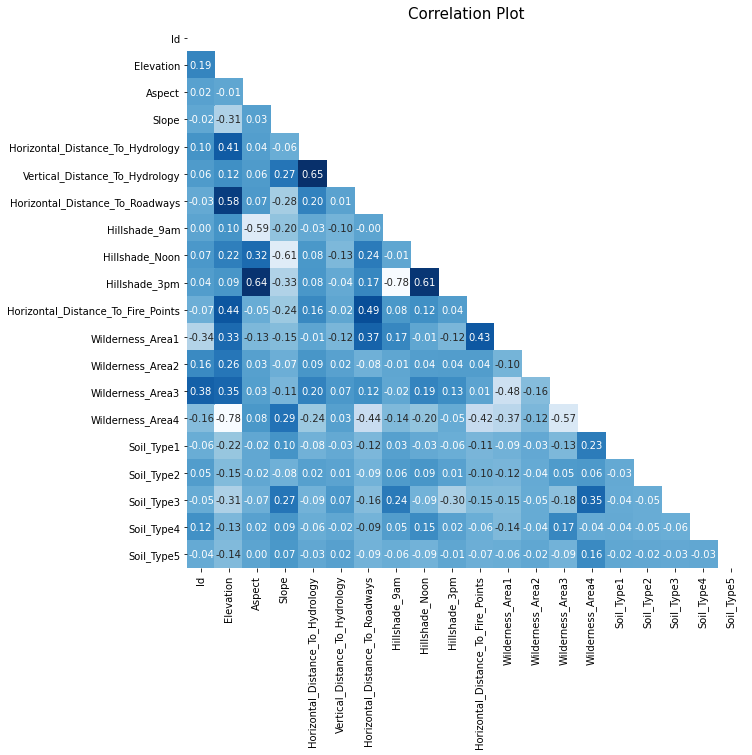

In [7]:
# correlation plot
corr = train.iloc[:, 0:20].corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot',size=15)
plt.show()
pass

# Model Baseline

1. Fit on train data
2. Generalize on dev data

In [37]:
train_labels

array([2, 3, 6, ..., 4, 1, 7])

In [68]:
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# K-nn 

knn_result = {}
k_values = [1,3,5,7,9,11,13]

for k in k_values:
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(train_data, train_labels)
    model_knn_pred = model_knn.predict(dev_data)
    knn_result[k] = metrics.f1_score(dev_labels, model_knn_pred, average="weighted")

# find best 'k'
best_k = max(knn_result, key=knn_result.get)

# build dataframe of f1_score at different k values
knn_result_df = pd.DataFrame(data = zip(c_values,list(knn_result.values())), columns = ['k','f1_score'])

# print results
print('K-nn Classifier:')
print('-'*50)
print(f'Best "k" in k-nn is: k={best_k}, F1 score={round(knn_result[best_k],3)}')
print()
print(knn_result_df)
print()

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# naive bayes

nb_result = {}
alpha_values = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]

for alpha in alpha_values:
    model_nb = BernoulliNB(alpha=alpha)
    model_nb.fit(train_data, train_labels)
    model_nb_pred = model_nb.predict(dev_data)
    nb_result[alpha] = metrics.f1_score(dev_labels, model_nb_pred, average="weighted")

# print best alpha
best_alpha = max(nb_result, key=nb_result.get)

# build dataframe of f1_score at different alpha values
nb_result_df = pd.DataFrame(data = zip(alpha_values,list(nb_result.values())), columns = ['alpha','f1_score'])


# print results
print('Bernoulli Naive Bayes Classifier:')
print('-'*50)
print(f'Best "alpha" in naive bayes is: alpha={best_alpha}, F1 score={round(nb_result[best_alpha],3)}')
print()
print(nb_result_df)
print()


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# logistic regression

logistic_result = {}
logistic_result_weights = {}
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

for c in c_values:
    model_logistic = LogisticRegression(C = c, solver="liblinear", multi_class="auto")
    model_logistic.fit(train_data, train_labels)
    model_logistic_pred = model_logistic.predict(dev_data)
    logistic_result[c] = metrics.f1_score(dev_labels, model_logistic_pred, average="weighted")

# find best c
best_c = max(logistic_result, key=logistic_result.get)

# build dataframe of f1_score at different c values
logistic_result_df = pd.DataFrame(data = zip(c_values,list(logistic_result.values())), columns = ['c','f1_score'])
logistic_result_df['regularization'] = 1 / np.array(c_values)

# print results
print('Logistic Regression Classifier:')
print('-'*50)
print(f'Best "c" in logistic regression is: c={best_c}, F1 score={round(logistic_result[best_c],3)}')
print()
print(logistic_result_df[['c','regularization','f1_score']])


K-nn Classifier:
--------------------------------------------------
Best "k" in k-nn is: k=1, F1 score=0.853

     k  f1_score
0  0.1  0.852675
1  0.2  0.836736
2  0.3  0.809592
3  0.4  0.795809
4  0.5  0.785400
5  0.6  0.776425
6  0.7  0.754291

Bernoulli Naive Bayes Classifier:
--------------------------------------------------
Best "alpha" in naive bayes is: alpha=2.0, F1 score=0.585

          alpha  f1_score
0  1.000000e-10  0.584583
1  1.000000e-04  0.584583
2  1.000000e-03  0.584583
3  1.000000e-02  0.584583
4  1.000000e-01  0.584583
5  5.000000e-01  0.584583
6  1.000000e+00  0.584583
7  2.000000e+00  0.585250
8  1.000000e+01  0.581460

Logistic Regression Classifier:
--------------------------------------------------
Best "c" in logistic regression is: c=0.4, F1 score=0.632

      c  regularization  f1_score
0   0.1       10.000000  0.630698
1   0.2        5.000000  0.621336
2   0.3        3.333333  0.615615
3   0.4        2.500000  0.632084
4   0.5        2.000000  0.629523
5 